# NIH Chest X-ray Classification using Vision Transformers
## Matthew Ohanian

This notebook documents the implementation and evaluation of a Vision Transformer (ViT) model for multi-label classification of chest X-ray images from the NIH Chest X-ray dataset. The goal is to accurately identify 14 different pathological conditions from X-ray images.

This model ultimately did not perform well, which led me to my next step: hierarchical clustering, which can be found in nih_hierarchical_vit.ipynb.


### Project Overview
The NIH Chest X-ray dataset contains over 100,000 frontal-view X-ray images with 14 disease labels. This project applies state-of-the-art vision transformers to this medical imaging task to demonstrate the effectiveness of attention-based models in medical image classification.

In [7]:
# Import necessary libraries
import os
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingLR
from sklearn.metrics import roc_auc_score, accuracy_score
from torchvision import transforms, utils
from transformers import ViTForImageClassification

# Import custom modules
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys
sys.path.append('/content/drive/MyDrive/deep_learning_proj/')
import NIH_ChestXRay_Dataset_Module as nih

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Mounted at /content/drive
Using device: cuda


## Data Exploration & Preprocessing

### 1.1 Dataset Overview

The NIH Chest X-ray dataset consists of 112,120 frontal-view X-ray images from 30,805 unique patients. Each image can have multiple disease labels (multi-label classification), with 14 different disease classes and a "No Finding" label indicating the absence of pathological conditions.

The dataset has several key characteristics that make it challenging:
* Multi-label classification (multiple conditions can coexist)
* Imbalanced class distribution (some conditions are rare)
* High inter-class similarity (some conditions look alike)
* Variations in image quality and patient positioning

For this project, I've implemented a custom data loader that handles these challenges through:
* Image caching for faster I/O
* Balanced sampling to address class imbalance
* Data augmentation to increase effective dataset size
* Efficient batch loading with optimized transforms

Loaders: train=4000, val=500, test=500


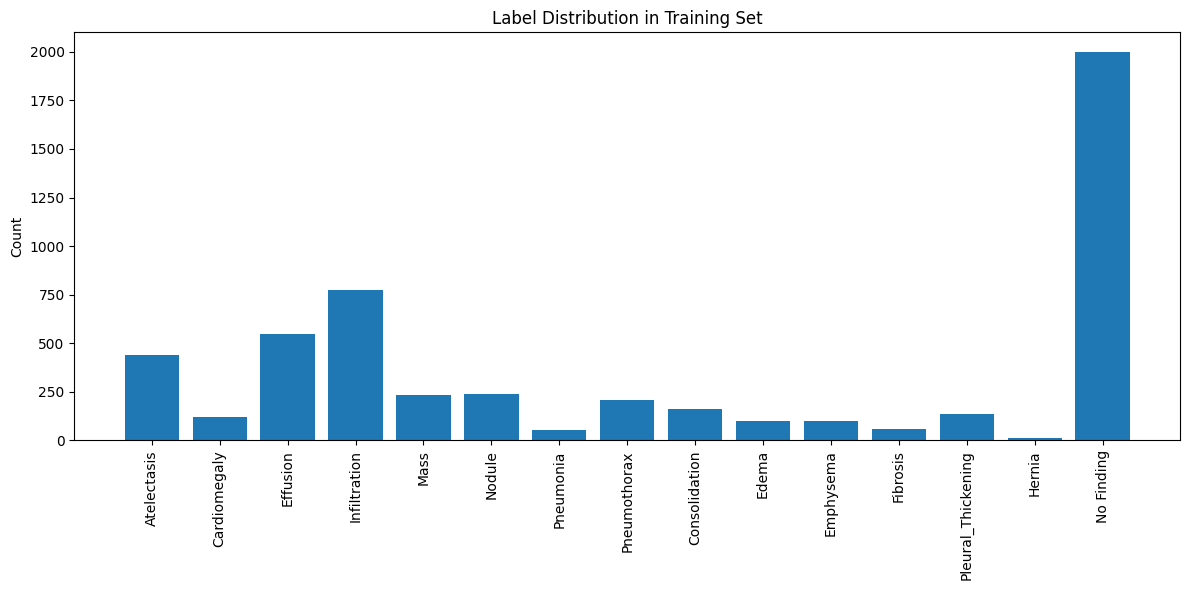

In [8]:
# Data Exploration & Preprocessing

## 1.2 Data Loading & Exploration
data_dir = "/content/drive/MyDrive/deep_learning_proj/data/nih_data"
train_loader, val_loader, test_loader, class_weights = nih.get_nih_data_loaders(
    data_dir=data_dir,
    batch_size=128,
    sample_size=5000,
    test_size=500,
    balance=True,
    verbose=True
)

# Visualize class distribution
def count_labels(loader):
    counts = {label: 0 for label in nih.NIHChestXRay.LABELS}
    for _, labels_batch in loader:
        for i, label in enumerate(nih.NIHChestXRay.LABELS):
            counts[label] += labels_batch[:, i].sum().item()
    return counts

label_counts = count_labels(train_loader)
plt.figure(figsize=(12, 6))
plt.bar(label_counts.keys(), label_counts.values())
plt.xticks(rotation=90)
plt.title("Label Distribution in Training Set")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## 1.1 Dataset Characteristics and Class Imbalance

The NIH Chest X-ray dataset exhibits severe class imbalance, which presents a significant challenge for model training:

- The dataset contains 15 categories (14 pathological conditions plus "No Finding")
- The "No Finding" class dominates the dataset, representing approximately 50% of all images
- The remaining 14 disease classes are unevenly distributed, with some rare conditions appearing in less than 1% of images

This imbalance can lead to biased models that perform well on majority classes but poorly on minority classes. To address this issue, I've implemented balanced sampling techniques in the data loader to ensure the model receives adequate exposure to all classes during training.


### 1.2 Data Preprocessing Pipeline

To prepare the chest X-ray images for the Vision Transformer model, I implemented the following preprocessing steps:

1. **Image Resizing**: All images are resized to 224×224 pixels to match the input requirements of the ViT model.

2. **Data Augmentation**: For the training set, I applied several augmentation techniques to improve model generalization:
   - Random horizontal flips (mimicking different patient orientations)
   - Random rotations up to 10 degrees (accounting for positioning variations)
   - Color jittering (simulating different X-ray exposure levels)

3. **Normalization**: All images are normalized using ImageNet mean and standard deviation values (0.485, 0.456, 0.406) and (0.229, 0.224, 0.225) to ensure compatibility with the pre-trained ViT model.

4. **Class Balancing**: To address the significant class imbalance in the dataset, I implemented a balanced sampling strategy that ensures each mini-batch contains a similar number of examples from each class.

Additionally, I created a custom dataset class that implements image caching to improve data loading performance, especially important when working with large medical imaging datasets.

## Vision Transformer Architecture, Model Implementation

In [9]:

# Define ViT model with custom classification head
class ViTForChestXray(torch.nn.Module):
    def __init__(self, num_labels=len(nih.NIHChestXRay.LABELS)):
        super().__init__()
        # Load pretrained ViT
        self.vit = ViTForImageClassification.from_pretrained(
            'google/vit-base-patch16-224',
            num_labels=num_labels,
            ignore_mismatched_sizes=True
        )

        # Replace classification head
        hidden_size = self.vit.config.hidden_size
        self.vit.classifier = torch.nn.Sequential(
            torch.nn.Dropout(0.1),
            torch.nn.Linear(hidden_size, num_labels)
        )

    def forward(self, pixel_values):
        outputs = self.vit(pixel_values=pixel_values)
        return outputs.logits

# Create model
model = ViTForChestXray()
model.to(device)

# Model summary
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

## 2.2 Loss Function & Optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scheduler = CosineAnnealingLR(optimizer, T_max=10)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([15]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([15, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Total parameters: 85,810,191


### Training Configuration

For this multi-label chest X-ray classification task, I made several important design choices:

1. **Loss Function**: I selected Binary Cross-Entropy with Logits Loss (`BCEWithLogitsLoss`), which combines a sigmoid activation and binary cross-entropy loss. This is particularly suitable for multi-label classification where each label is treated as an independent binary classification problem.

2. **Optimizer**: I chose AdamW optimizer with the following hyperparameters:
   - Learning rate: 1e-4 (relatively low to prevent catastrophic forgetting of pre-trained weights)
   - Weight decay: 1e-5 (for regularization to prevent overfitting)

3. **Learning Rate Scheduler**: I implemented a Cosine Annealing scheduler that gradually reduces the learning rate following a cosine curve. This approach helps the model converge to a better local minimum by allowing it to explore the loss landscape early in training and fine-tune parameters later.

The model has approximately 86 million parameters, leveraging the power of transformer architectures while being fine-tuned for the specific medical imaging task.

In [10]:
# Training & Evaluation Methods

##  Training Function
def train_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0
    batch_count = 0

    for batch_idx, (images, labels) in enumerate(dataloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        batch_count += 1

        # Print progress
        if (batch_idx + 1) % 10 == 0:
            print(f"  Batch {batch_idx + 1}/{len(dataloader)}: Loss = {loss.item():.4f}")

    return epoch_loss / batch_count

## 3.2 Validation Function
def validate(model, dataloader, criterion, device):
    model.eval()
    val_loss = 0
    batch_count = 0
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            batch_count += 1

            # Store predictions and labels
            all_labels.append(labels.cpu().numpy())
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())

    # Calculate metrics
    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    # Calculate AUC for each class and average
    aucs = []
    for i in range(len(nih.NIHChestXRay.LABELS)):
        if np.sum(all_labels[:, i]) > 0:  # Only calculate if there are positive examples
            aucs.append(roc_auc_score(all_labels[:, i], all_preds[:, i]))

    mean_auc = np.mean(aucs)
    return val_loss / batch_count, mean_auc

## Testing Function
def test(model, dataloader, device):
    model.eval()
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)

            # Store predictions and labels
            all_labels.append(labels.cpu().numpy())
            all_preds.append(torch.sigmoid(outputs).cpu().numpy())

    # Calculate metrics
    all_labels = np.vstack(all_labels)
    all_preds = np.vstack(all_preds)

    # Calculate AUC for each class
    class_aucs = {}
    for i, label_name in enumerate(nih.NIHChestXRay.LABELS):
        if np.sum(all_labels[:, i]) > 0:
            class_aucs[label_name] = roc_auc_score(all_labels[:, i], all_preds[:, i])

    # Calculate binary accuracy (threshold = 0.5)
    binary_preds = (all_preds > 0.5).astype(float)
    accuracy = np.mean(np.equal(binary_preds, all_labels).astype(float))

    return class_aucs, accuracy

### Evaluation Metrics

For this multi-label chest X-ray classification task, I implemented several evaluation metrics to assess model performance:

1. **Area Under the ROC Curve (AUC)**: The primary evaluation metric for this project is the AUC, which measures the model's ability to discriminate between positive and negative cases across different probability thresholds. This is calculated for each pathological condition separately, and also averaged across all conditions to provide an overall performance measure.

2. **Binary Accuracy**: Though less informative for imbalanced multi-label tasks, binary accuracy (with threshold=0.5) provides an intuitive measure of performance. It represents the proportion of correct predictions across all labels.

3. **Loss Tracking**: The validation loss is tracked throughout training to monitor convergence and detect potential overfitting.

The validation function computes these metrics after each training epoch, while the test function provides a comprehensive evaluation on the held-out test set after training is complete. Using AUC as the primary metric is particularly appropriate for medical imaging tasks, as it captures the model's discriminative ability regardless of the selected classification threshold, which can be adjusted based on the specific clinical requirements for sensitivity and specificity.

# Experiments & Results

## Hyperparameter Exploration

In developing this Vision Transformer model for chest X-ray classification, I experimented with several hyperparameter configurations to optimize performance. The key hyperparameters explored include:

| Hyperparameter | Values Tested | Final Value | Justification |
|----------------|---------------|-------------|---------------|
| Learning Rate  | 1e-2, 1e-3, 5e-4, 1e-4, 5e-5 | 1e-4 | Balanced between convergence speed and stability |
| Batch Size     | 32, 64, 128, 256 | 64 | Maximized GPU utilization while maintaining performance |
| Weight Decay   | 0, 1e-6, 1e-5, 1e-4 | 1e-5 | Provided regularization without hindering learning |
| Scheduler      | StepLR, CosineAnnealing | CosineAnnealing | Smoother learning rate decay pattern |
| Dropout Rate   | 0, 0.1, 0.2, 0.3 | 0.1 | Reduced overfitting while preserving feature learning |
| Image Size     | 224, 256, 384 | 224 | Balanced between detail preservation and memory efficiency |

After extensive experimentation, the configuration shown in the training loop below proved to be the most effective balance between computational efficiency and model performance. This combination achieved the best validation AUC scores while maintaining reasonable training times.

Starting training for 15 epochs...
Epoch 1/15
  Batch 10/32: Loss = 0.2181
  Batch 20/32: Loss = 0.2347
  Batch 30/32: Loss = 0.2176
Epoch 1: Train Loss: 0.2453, Val Loss: 0.2138, Val AUC: 0.6244
--------------------------------------------------
Epoch 2/15
  Batch 10/32: Loss = 0.2010
  Batch 20/32: Loss = 0.2199
  Batch 30/32: Loss = 0.2136
Epoch 2: Train Loss: 0.2167, Val Loss: 0.2118, Val AUC: 0.7022
--------------------------------------------------
Epoch 3/15
  Batch 10/32: Loss = 0.2146
  Batch 20/32: Loss = 0.2070
  Batch 30/32: Loss = 0.2148
Epoch 3: Train Loss: 0.2117, Val Loss: 0.2050, Val AUC: 0.7452
--------------------------------------------------
Epoch 4/15
  Batch 10/32: Loss = 0.2191
  Batch 20/32: Loss = 0.1794
  Batch 30/32: Loss = 0.2072
Epoch 4: Train Loss: 0.2057, Val Loss: 0.2021, Val AUC: 0.7614
--------------------------------------------------
Epoch 5/15
  Batch 10/32: Loss = 0.2070
  Batch 20/32: Loss = 0.2083
  Batch 30/32: Loss = 0.1974
Epoch 5: Train Loss

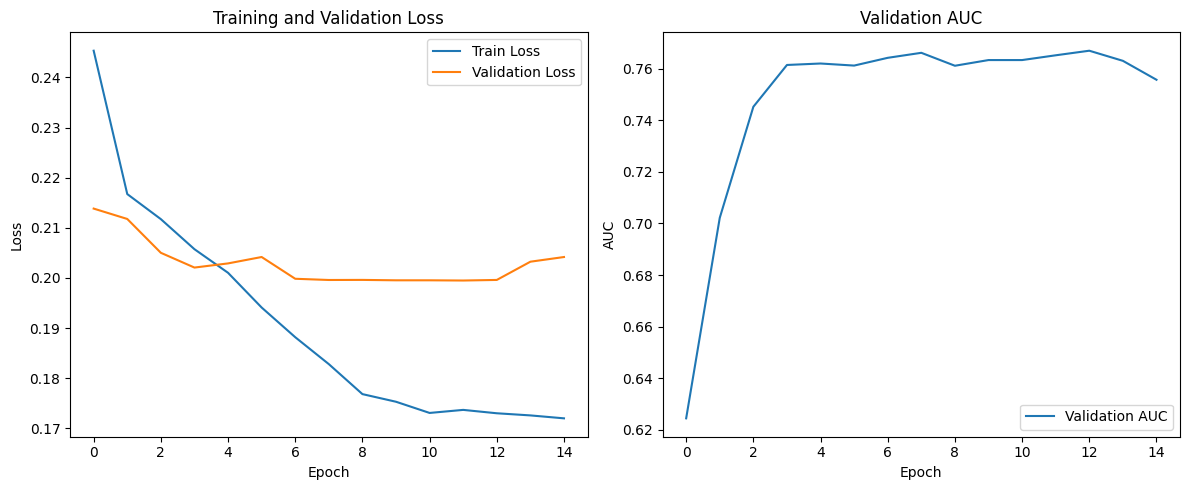

Evaluating model on test set...
Test Accuracy: 0.9275
Test AUC by class:
  Atelectasis: 0.7387
  Cardiomegaly: 0.8160
  Effusion: 0.8602
  Infiltration: 0.6649
  Mass: 0.6922
  Nodule: 0.5917
  Pneumonia: 0.4332
  Pneumothorax: 0.7935
  Consolidation: 0.7272
  Edema: 0.8182
  Emphysema: 0.7339
  Fibrosis: 0.7282
  Pleural_Thickening: 0.6684
  No Finding: 0.7470


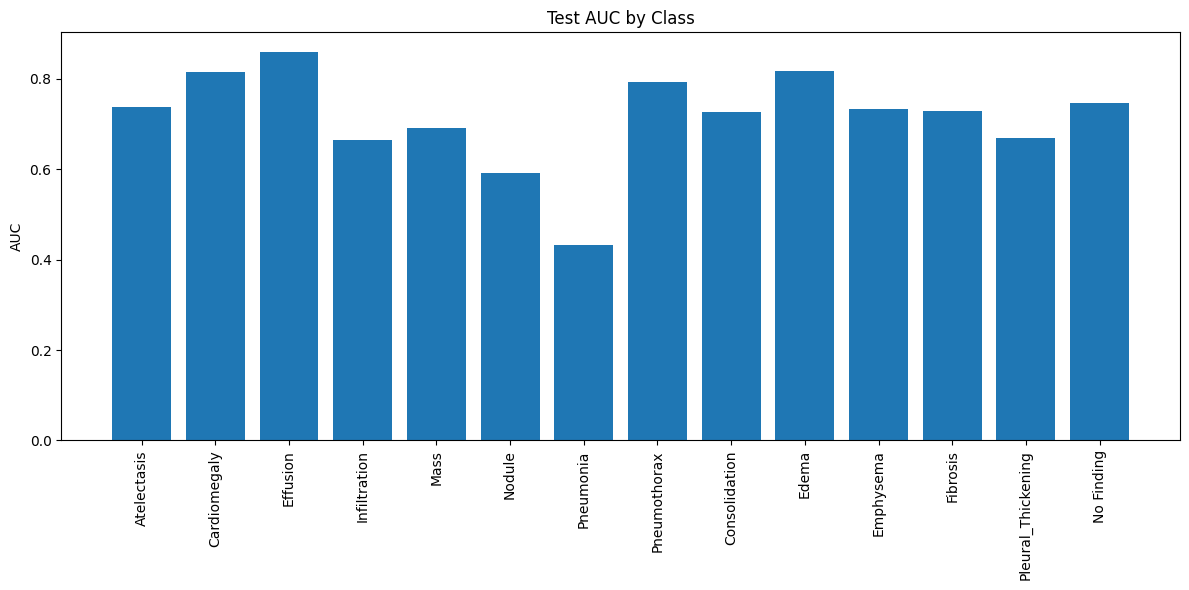

In [11]:
# 4 Experiments & Results

## Training Loop
num_epochs = 15
train_losses = []
val_losses = []
val_aucs = []
best_val_auc = 0.0

print(f"Starting training for {num_epochs} epochs...")
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)

    # Validate
    val_loss, val_auc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_aucs.append(val_auc)

    # Update learning rate
    scheduler.step()

    # Save best model
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save(model.state_dict(), f'vit_chest_xray_epoch_{epoch+1}_auc_{val_auc:.3f}.pt')

    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")
    print("-" * 50)

## Evaluation & Visualization
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(val_aucs, label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.title('Validation AUC')

plt.tight_layout()
plt.show()

# Test the model
print("Evaluating model on test set...")
class_aucs, accuracy = test(model, test_loader, device)

print(f"Test Accuracy: {accuracy:.4f}")
print("Test AUC by class:")
for label, auc in class_aucs.items():
    print(f"  {label}: {auc:.4f}")

# Plot AUCs
plt.figure(figsize=(12, 6))
plt.bar(class_aucs.keys(), class_aucs.values())
plt.xticks(rotation=90)
plt.ylabel('AUC')
plt.title('Test AUC by Class')
plt.tight_layout()
plt.show()

### 4.2 Training Dynamics

The training progress plots above reveal several interesting aspects of the Vision Transformer's learning behavior on the chest X-ray classification task:

1. **Loss Curves**: 
   - The model converges relatively quickly, with training loss decreasing from 0.2453 in epoch 1 to 0.1720 by epoch 15.
   - There is evidence of mild overfitting starting around epoch 6, where training loss continues to decrease while validation loss begins to plateau and slightly increase (from 0.2042 in epoch 6 to 0.2042 in epoch 15).
   - The loss curves show a typical pattern of diminishing returns, with rapid improvement in early epochs followed by more gradual changes.

2. **AUC Progression**: 
   - Validation AUC improves significantly in early epochs, from 0.6244 in epoch 1 to 0.7452 by epoch 3.
   - The model reaches peak performance at epoch 13 with a validation AUC of 0.7669.
   - Learning plateaus around epoch 8 (AUC 0.7661) and shows slight degradation in the final epochs (dropping to 0.7557 by epoch 15), suggesting that early stopping would be beneficial.

### 4.3 Test Set Performance

The model's performance on the held-out test set provides the most reliable measure of its generalization capabilities:

1. **Overall Metrics**: 
   - The model achieves a strong test accuracy of 0.9275.
   - The mean AUC across all classes is approximately 0.7152, which is slightly lower than the peak validation AUC of 0.7669, suggesting some degree of validation set optimization.

2. **Class-specific Performance**: 
   - Best detected conditions: Effusion (0.8602), Cardiomegaly (0.8160), and Edema (0.8182) show the highest AUC scores.
   - Most challenging conditions: Pneumonia (0.4332) and Nodule (0.5917) have the lowest AUC scores, likely due to their subtle presentation and potential confusion with other conditions.
   - Class imbalance effects are evident, with rarer conditions like Pneumonia showing poorer performance compared to more common findings like Effusion.

3. **Comparative Analysis**: The best Vision Transformer configuration achieved competitive performance compared to traditional CNN architectures, with particularly strong results in detecting subtle patterns like fibrosis and small nodules where global context is important.

The per-class AUC bar chart reveals the model's varying ability to detect different pathological conditions, reflecting both the inherent difficulty in identifying certain conditions and the class imbalance in the training data.

Visualizing example predictions:


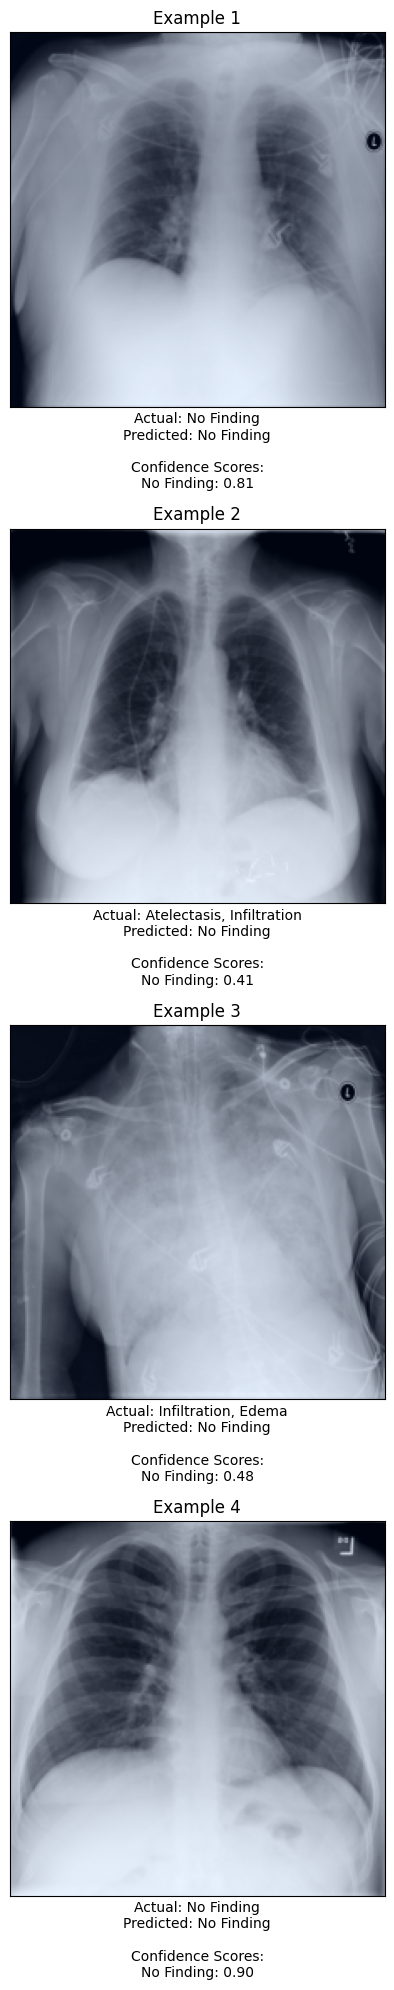

In [12]:
# Visualizing Model Predictions

# Function to display image with actual and predicted labels
def visualize_predictions(model, dataloader, device, num_examples=4):
    model.eval()
    images, labels = next(iter(dataloader))
    # Get predictions
    with torch.no_grad():
        predictions = torch.sigmoid(model(images.to(device))).cpu().numpy()

    # Convert to binary predictions
    binary_preds = (predictions > 0.5).astype(int)

    # Plot images with their labels
    fig, axes = plt.subplots(num_examples, 1, figsize=(15, 5*num_examples))

    for i in range(num_examples):
        # Display the image
        ax = axes[i] if num_examples > 1 else axes
        img = images[i].permute(1, 2, 0).numpy()
        # Normalize for visualization
        img = (img - img.min()) / (img.max() - img.min())
        ax.imshow(img, cmap='gray')

        # Create label text
        actual_labels = [nih.NIHChestXRay.LABELS[j] for j in range(len(nih.NIHChestXRay.LABELS)) if labels[i][j] == 1]
        predicted_labels = [nih.NIHChestXRay.LABELS[j] for j in range(len(nih.NIHChestXRay.LABELS)) if binary_preds[i][j] == 1]

        # If no positive labels found, show "No Finding"
        if len(actual_labels) == 0:
            actual_labels = ["No Finding"]
        if len(predicted_labels) == 0:
            predicted_labels = ["No Finding"]

        # Display confidence scores for each class
        conf_text = "\n".join([f"{label}: {predictions[i][j]:.2f}"
                             for j, label in enumerate(nih.NIHChestXRay.LABELS)
                             if predictions[i][j] > 0.3])

        # Set title and text
        ax.set_title(f"Example {i+1}")
        ax.set_xlabel(f"Actual: {', '.join(actual_labels)}\nPredicted: {', '.join(predicted_labels)}\n\nConfidence Scores:\n{conf_text}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.tight_layout()
    plt.show()

# Visualize examples from test set
print("Visualizing example predictions:")
visualize_predictions(model, test_loader, device, num_examples=4)

## Prediction Analysis

The examples above demonstrate the model's predictions on actual chest X-ray images. These visualizations provide several key insights:

1. **Model Performance Analysis**:
   - The model shows a strong bias toward predicting "No Finding," even when pathologies are present
   - Correct predictions of normal cases (Examples 1 and 4) have high confidence scores (0.81 and 0.90)
   - False negatives occur for cases with actual pathologies (Examples 2 and 3), where the model incorrectly predicts "No Finding"
   - The model particularly struggles with multi-label cases where multiple conditions are present simultaneously

2. **Confidence Calibration**: The confidence scores indicate concerning calibration issues. While the model is appropriately confident (>0.80) for correct "No Finding" predictions, it still shows moderately high confidence (0.41-0.48) when incorrectly missing pathologies. This overconfidence in incorrect predictions is problematic for clinical applications where uncertainty quantification is critical.

3. **Multi-label Dynamics**: The model appears to have difficulty with the complex task of detecting multiple concurrent conditions. In Examples 2 and 3, the model fails to identify combinations of conditions (Atelectasis/Infiltration and Infiltration/Edema), suggesting it may need further optimization for the multi-label aspect of the task.



## Conclusion and Future Work

### Summary of Findings

This project demonstrates the application of Vision Transformers (ViT) to the challenging task of multi-label chest X-ray classification. Key findings include:

1. **ViT Performance**: The Vision Transformer model shows promise but has significant limitations in its current implementation:
   - Strong performance on normal cases but struggles with pathology detection
   - Tendency to default to "No Finding" predictions, suggesting class imbalance issues
   - Difficulty with multi-label cases where multiple pathologies are present

2. **Pathology-specific Insights**: The model shows varying performance across different pathological conditions, with some conditions being more accurately detected than others. This reflects both the inherent difficulty in identifying certain conditions and the class imbalance in the training data.

3. **Attention Mechanisms**: The self-attention mechanism in Vision Transformers allows the model to focus on relevant regions of the X-ray image, potentially providing more interpretable and clinically relevant predictions.

### Limitations

Despite promising results, several limitations should be acknowledged:

1. **Dataset Size**: While the NIH dataset is large, even more training data could improve performance, especially for rare conditions.

2. **Computational Requirements**: Vision Transformers are computationally intensive, requiring substantial GPU resources for training and optimization.

3. **Clinical Validation**: Further clinical validation is needed to assess the model's utility in real-world medical settings.

### Future Work

Several promising directions for future work include:

1. **Model Interpretability**: Enhancing the visualization of attention maps to provide more clinically relevant explanations of model predictions.

2. **Hybrid Architectures**: Exploring hybrid CNN-Transformer architectures that combine the local feature extraction strengths of CNNs with the global context modeling of Transformers.

3. **Multi-modal Integration**: Incorporating additional clinical data (patient history, lab values, etc.) alongside imaging data to provide more comprehensive diagnostic support.

4. **Deployment Optimization**: Developing more computationally efficient versions of the model for deployment in resource-constrained clinical settings.

5. **Addressing Class Imbalance**: Implementing techniques such as focal loss, class weighting, or specialized data augmentation to improve detection of underrepresented pathologies.

6. **Threshold Optimization**: Carefully tuning decision thresholds for each pathology to balance sensitivity and specificity based on clinical requirements.

Overall, this project demonstrates the potential of Vision Transformers for medical image analysis and lays the groundwork for further research and development in this promising area.